<a href="https://colab.research.google.com/github/adityabalu/ssl-nov-2024/blob/main/rotation_ssl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Learning Pipeline: Rotation Prediction, Clustering, and Downstream Classification

This notebook demonstrates a self-supervised learning approach using rotation prediction as a pretext task. We then explore clustering the learned features and evaluate them on a downstream classification task. Self-supervised learning allows the model to learn useful representations without relying on labeled data, which can then be used for various downstream tasks.


#Import Libraries and Set Up Device

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Set device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Rotation Transformation

In self-supervised learning, we can create a "pretext task" by applying rotations to images. The model learns to recognize these rotations, allowing it to learn spatial features. Here, we define a transformation that randomly rotates images by 0°, 90°, 180°, or 270°.


 # Define Rotation Transformation

In [ ]:
class RotationTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = int(np.random.choice(self.angles))  # Ensure angle is an int
        return transforms.functional.rotate(x, angle), angle


# Load CIFAR-10 Dataset with Rotation Transformation

## Load CIFAR-10 Dataset with Rotation Transformation

We load the CIFAR-10 dataset and apply the rotation transformation. Each image is randomly rotated by one of the four angles, and the angle is used as a label for training. This serves as a self-supervised task to teach the model spatial reasoning without labeled classes.


In [ ]:
# Define base transformation for CIFAR-10 images
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])
rotation_transform = RotationTransform([0, 90, 180, 270])

class RotationDataset(datasets.CIFAR10):
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img, rotation_label = rotation_transform(img)
        return img, rotation_label // 90  # Convert angle to class label (0, 1, 2, 3)

# Load rotated CIFAR-10 images for rotation prediction
train_dataset = RotationDataset(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Define Model for Rotation Prediction

## Define Model with Rotation Prediction Head

We use a ResNet-18 model as our base encoder. The encoder learns feature representations, while an additional head classifies the rotation angle (0, 90, 180, or 270 degrees). This approach enables the model to learn meaningful features from unlabeled data.


In [ ]:
class RotationPredictionModel(nn.Module):
    def __init__(self, base_model):
        super(RotationPredictionModel, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()  # Remove the original classification layer

        # Rotation prediction head
        self.rotation_head = nn.LazyLinear(512, 4)  # 4 possible rotation angles

    def forward(self, x):
        features = self.encoder(x)
        rotation_logits = self.rotation_head(features)
        return rotation_logits, features

# Initialize model, loss function, and optimizer
model = RotationPredictionModel(resnet18(pretrained=False)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Train the Model on Rotation Prediction

## Train the Model on Rotation Prediction

We train the model to predict the rotation of each image. This enables the model to learn useful feature representations in a self-supervised way. Each epoch represents a full pass through the data, where the model learns to distinguish between the rotated images.


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for (x, rotation_label) in train_loader:
        x, rotation_label = x.to(device), rotation_label.to(device)

        # Forward pass
        rotation_logits, _ = model(x)
        loss = criterion(rotation_logits, rotation_label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Rotation Prediction Loss: {epoch_loss/len(train_loader):.4f}')

print("Rotation Prediction Training Complete.")

# Save the model weights
model_save_path = "rotation_prediction_model.pth"
torch.save(model.state_dict(), model_save_path)
print("Model weights saved to", model_save_path)

# To load the model weights
model.load_state_dict(torch.load(model_save_path))
model.to(device)  # Ensure the model is on the correct device
print("Model weights loaded successfully.")


Epoch [1/10], Rotation Prediction Loss: 1.2616
Epoch [2/10], Rotation Prediction Loss: 1.1954


KeyboardInterrupt: 

## Clustering with Feature Extraction and Visualization

With the trained encoder, we extract feature representations and perform clustering to examine the learned features. Using PCA, we reduce the dimensions for visualization, then apply K-means clustering to group similar images.


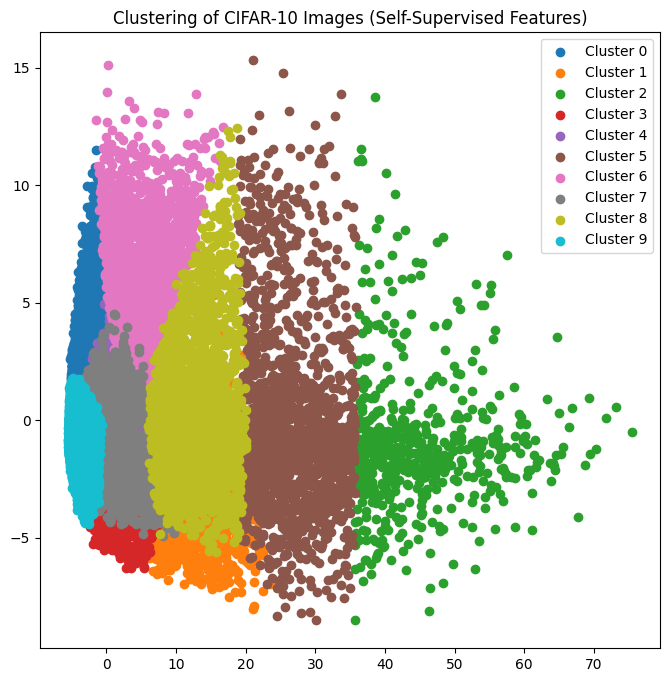

In [ ]:
features = []
with torch.no_grad():
    for (x, _) in train_loader:
        x = x.to(device)
        _, feature = model(x)
        features.append(feature.cpu().numpy())
features = np.concatenate(features)

# Dimensionality reduction with PCA for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# K-means clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(features)

# Plot the clustered features
plt.figure(figsize=(8, 8))
for i in range(num_clusters):
    cluster = features_2d[cluster_labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')
plt.title("Clustering of CIFAR-10 Images (Self-Supervised Features)")
plt.legend()
plt.show()


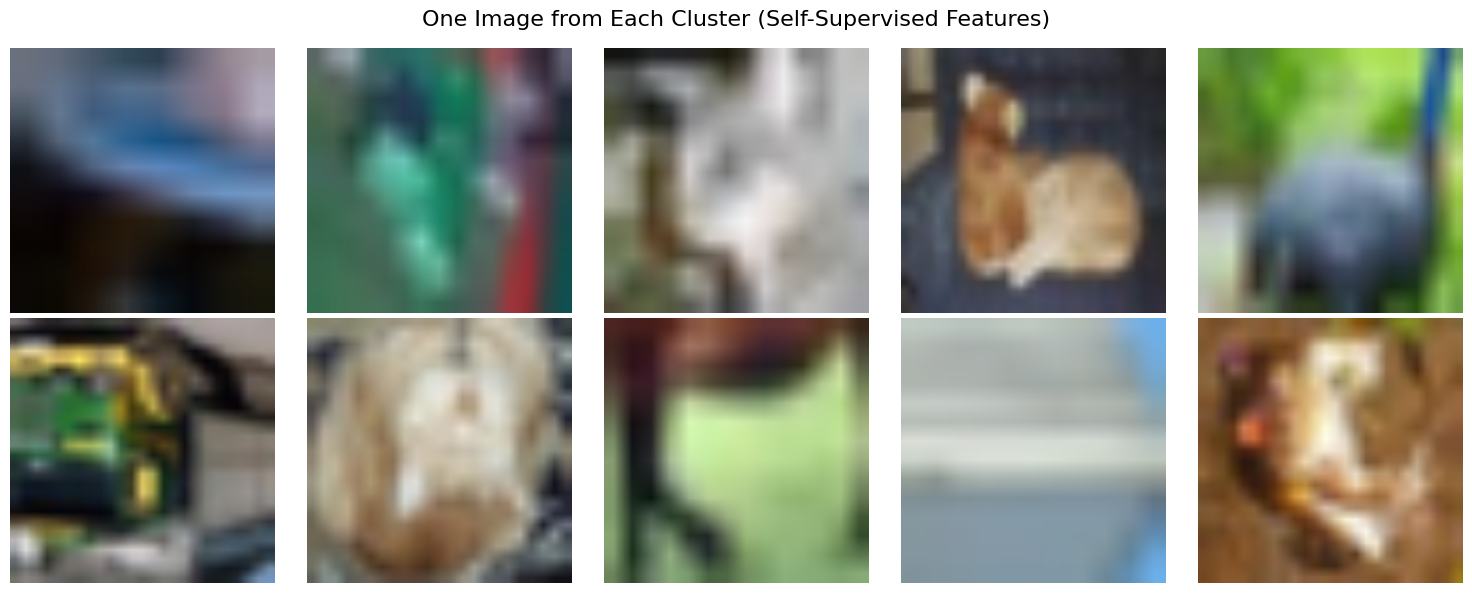

In [ ]:
# Create a dictionary to store one image per cluster
clustered_images = {i: None for i in range(num_clusters)}  # None to indicate no image is stored yet
for idx, label in enumerate(cluster_labels):
    # Store the first image found for each cluster
    if clustered_images[label] is None:
        clustered_images[label] = train_loader.dataset[idx][0]  # Store the image directly

# Plot images in rows (2 rows, 5 columns)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns (10 images or cluster)

# Now we plot one image per cluster
axs = axs.flatten()
for cluster_idx in range(num_clusters):
    image = clustered_images[cluster_idx]
    if image is not None:  # Check if there is an image for this cluster
        axs[cluster_idx].imshow(image.numpy().transpose(1, 2, 0))
        axs[cluster_idx].axis('off')
    else:
        axs[cluster_idx].axis('off')

plt.suptitle("One Image from Each Cluster (Self-Supervised Features)", fontsize=16)
plt.tight_layout()
plt.show()


## Downstream Classification Task Setup

To evaluate the quality of learned representations, we perform a downstream classification task on CIFAR-10. Here, we freeze the encoder weights and train only the classification head to classify CIFAR-10 classes.


In [ ]:
# Freeze the encoder's weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Add a classification head for CIFAR-10
class DownstreamClassifier(nn.Module):
    def __init__(self, base_model):
        super(DownstreamClassifier, self).__init__()
        self.encoder = base_model.encoder
        self.classification_head = nn.Linear(512, 10)

    def forward(self, x):
        features = self.encoder(x)
        class_logits = self.classification_head(features)
        return class_logits

downstream_model = DownstreamClassifier(model).to(device)
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.Adam(downstream_model.classification_head.parameters(), lr=1e-3)


## Train the Downstream Model on CIFAR-10

We train only the classification head on CIFAR-10, keeping the encoder weights frozen. This training assesses how well the self-supervised features support classification.


In [ ]:
classification_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]), download=True)
classification_test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]), download=True)
classification_train_loader = DataLoader(classification_train_dataset, batch_size=64, shuffle=True, num_workers=2)
classification_test_loader = DataLoader(classification_test_dataset, batch_size=64, shuffle=False, num_workers=2)

num_epochs = 5
for epoch in range(num_epochs):
    downstream_model.train()
    train_loss = 0
    for x, labels in classification_train_loader:
        x, labels = x.to(device), labels.to(device)

        class_logits = downstream_model(x)
        loss = classification_criterion(class_logits, labels)

        classification_optimizer.zero_grad()
        loss.backward()
        classification_optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Classification Loss: {train_loss/len(classification_train_loader):.4f}')


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Classification Loss: 1.9119
Epoch [2/5], Classification Loss: 1.8264
Epoch [3/5], Classification Loss: 1.8015
Epoch [4/5], Classification Loss: 1.7840
Epoch [5/5], Classification Loss: 1.7719


## Evaluate and Visualize Downstream Classification Performance

Finally, we evaluate the downstream model's accuracy on CIFAR-10. This metric reflects the quality of self-supervised features. We also plot histograms comparing predicted and true labels to visualize performance.


Downstream Classification Accuracy: 28.69%


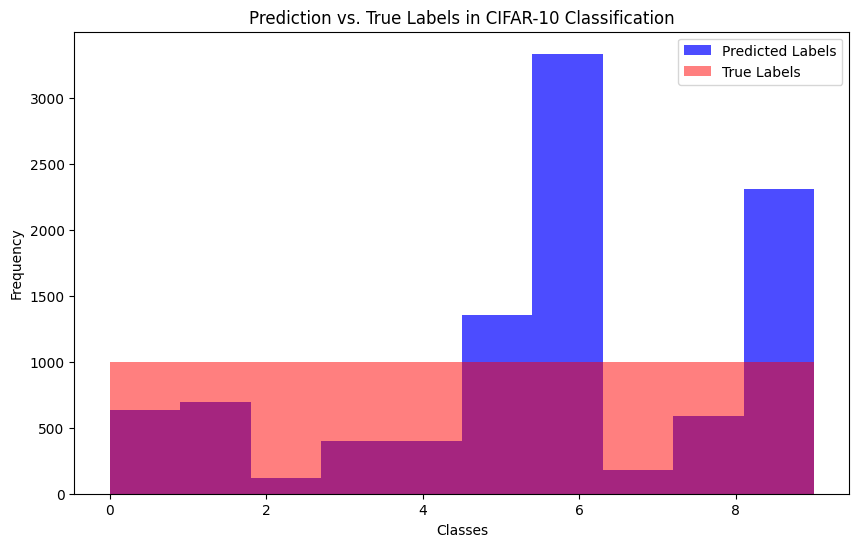

In [ ]:
downstream_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, labels in classification_test_loader:
        x, labels = x.to(device), labels.to(device)
        class_logits = downstream_model(x)
        preds = torch.argmax(class_logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Downstream Classification Accuracy: {accuracy * 100:.2f}%")

# Visualization of predictions
plt.figure(figsize=(10, 6))
plt.hist(all_preds, bins=10, color='blue', alpha=0.7, label='Predicted Labels')
plt.hist(all_labels, bins=10, color='red', alpha=0.5, label='True Labels')
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Prediction vs. True Labels in CIFAR-10 Classification")
plt.legend()
plt.show()


## Step 6: Load ImageNet-Pretrained Model and Perform Clustering

We load an ImageNet-pretrained ResNet-18 model to compare its learned features with the self-supervised model. The pretrained model’s features will be extracted, reduced using PCA, and clustered using K-means to compare clustering results.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


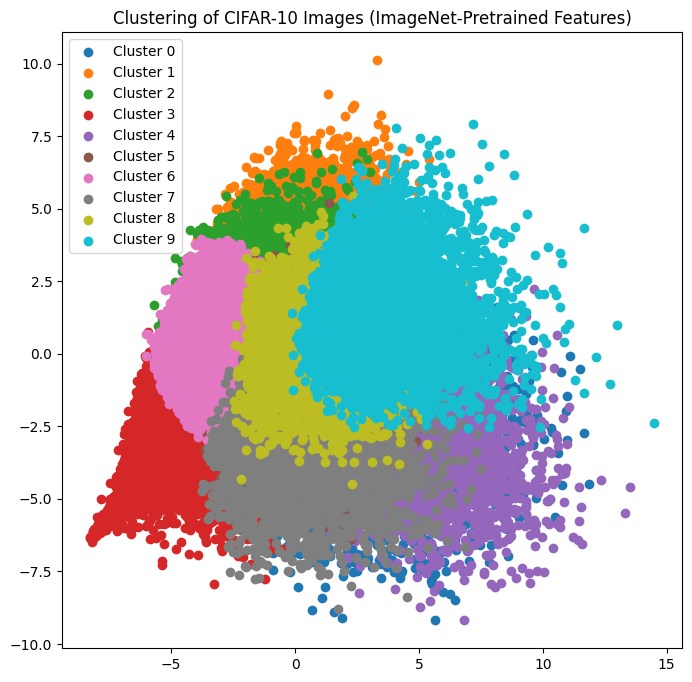

In [ ]:
# Load ImageNet-pretrained ResNet-18 model
imagenet_model = resnet18(pretrained=True)
imagenet_model.fc = nn.Identity()  # Remove final classification layer
imagenet_model = imagenet_model.to(device)
imagenet_model.eval()

# Extract features from ImageNet-pretrained model
imagenet_features = []
with torch.no_grad():
    for (x, _) in train_loader:
        x = x.to(device)
        feature = imagenet_model(x)
        imagenet_features.append(feature.cpu().numpy())
imagenet_features = np.concatenate(imagenet_features)

# Reduce dimensions with PCA and perform K-means clustering
imagenet_features_2d = PCA(n_components=2).fit_transform(imagenet_features)
imagenet_cluster_labels = KMeans(n_clusters=10, random_state=0).fit_predict(imagenet_features)

# Plot ImageNet-pretrained model clusters
plt.figure(figsize=(8, 8))
for i in range(10):
    cluster = imagenet_features_2d[imagenet_cluster_labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')
plt.title("Clustering of CIFAR-10 Images (ImageNet-Pretrained Features)")
plt.legend()
plt.show()


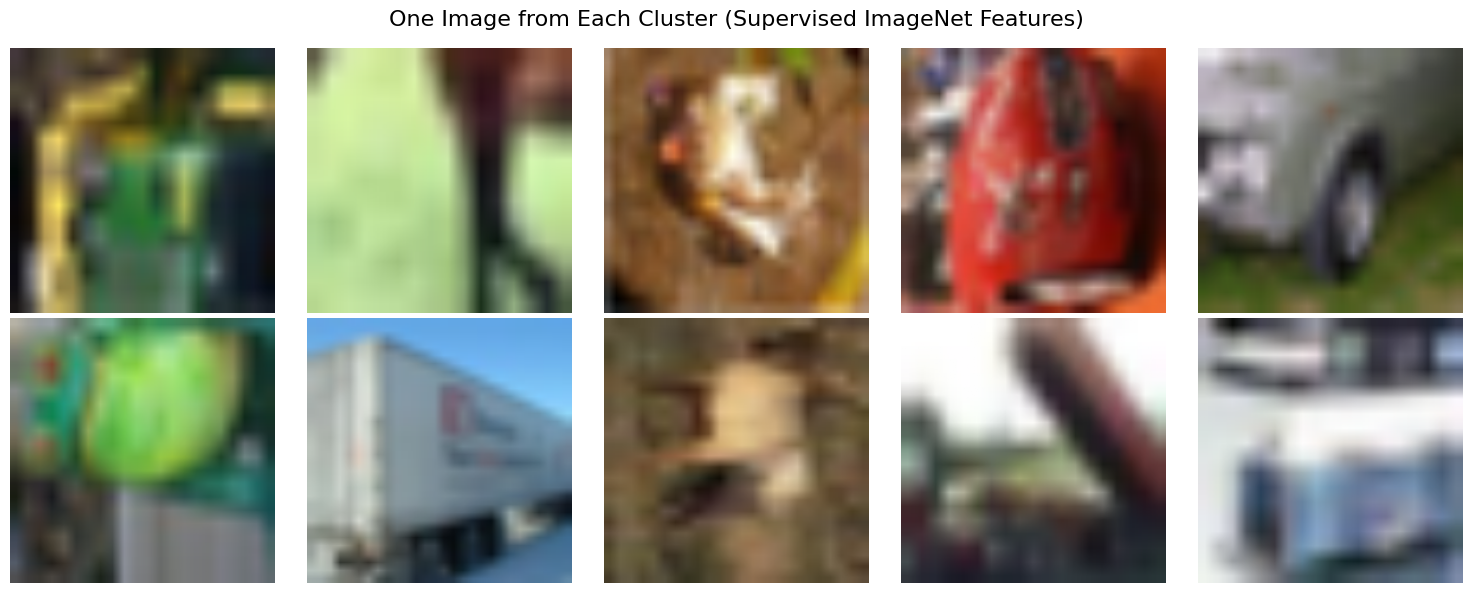

In [ ]:
# Create a dictionary to store one image per cluster
clustered_images = {i: None for i in range(10)}  # None to indicate no image is stored yet
for idx, label in enumerate(imagenet_cluster_labels):
    # Store the first image found for each cluster
    if clustered_images[label] is None:
        clustered_images[label] = train_loader.dataset[idx][0]  # Store the image directly

# Plot images in rows (2 rows, 5 columns)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns (10 images or clusters)

# Plot one image per cluster
axs = axs.flatten()
for cluster_idx in range(10):
    image = clustered_images[cluster_idx]
    if image is not None:  # Check if there is an image stored for this cluster
        axs[cluster_idx].imshow(image.numpy().transpose(1, 2, 0))
        axs[cluster_idx].axis('off')
    else:
        axs[cluster_idx].axis('off')

plt.suptitle("One Image from Each Cluster (Supervised ImageNet Features)", fontsize=16)
plt.tight_layout()
plt.show()


## Step 7: Downstream Classification with ImageNet-Pretrained Model

To assess the quality of the ImageNet-pretrained features, we add a classification head and train it on CIFAR-10, comparing the performance with the self-supervised model. This helps gauge how effectively the pretext task aligns with the classification objective.


In [ ]:
# Add classification head to ImageNet-pretrained model for CIFAR-10
imagenet_downstream_model = nn.Sequential(
    imagenet_model,
    nn.Linear(512, 10)  # CIFAR-10 has 10 classes
).to(device)

# Define criterion and optimizer for ImageNet model
imagenet_criterion = nn.CrossEntropyLoss()
imagenet_optimizer = optim.Adam(imagenet_downstream_model[1].parameters(), lr=1e-3)  # Only train the new head

# Training loop for ImageNet-pretrained model on CIFAR-10 classification
num_epochs = 5
for epoch in range(num_epochs):
    imagenet_downstream_model.train()
    train_loss = 0
    for x, labels in classification_train_loader:
        x, labels = x.to(device), labels.to(device)

        # Forward pass
        class_logits = imagenet_downstream_model(x)
        loss = imagenet_criterion(class_logits, labels)

        # Backpropagation
        imagenet_optimizer.zero_grad()
        loss.backward()
        imagenet_optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], ImageNet Classification Loss: {train_loss/len(classification_train_loader):.4f}')

# Evaluate ImageNet-pretrained model on CIFAR-10 test set
imagenet_downstream_model.eval()
imagenet_preds, imagenet_labels = [], []
with torch.no_grad():
    for x, labels in classification_test_loader:
        x, labels = x.to(device), labels.to(device)
        class_logits = imagenet_downstream_model(x)
        preds = torch.argmax(class_logits, dim=1)

        imagenet_preds.extend(preds.cpu().numpy())
        imagenet_labels.extend(labels.cpu().numpy())

# Calculate accuracy for ImageNet-pretrained model
imagenet_accuracy = accuracy_score(imagenet_labels, imagenet_preds)
print(f"ImageNet-Pretrained Model Classification Accuracy: {imagenet_accuracy * 100:.2f}%")


Epoch [1/5], ImageNet Classification Loss: 0.8397
Epoch [2/5], ImageNet Classification Loss: 0.6285
Epoch [3/5], ImageNet Classification Loss: 0.5946
Epoch [4/5], ImageNet Classification Loss: 0.5781
Epoch [5/5], ImageNet Classification Loss: 0.5667
ImageNet-Pretrained Model Classification Accuracy: 79.31%
